In [ ]:
pip install tensorflow
pip install requests
pip install pandas
pip install matplotlib
pip install torch
pip install plotly
pip install scikit-learn
pip install seaborn

In [1]:
import pandas as pd
import requests
from datetime import datetime
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import json
import sqlite3
import os

In [2]:
def merge_json_objects(obj1, obj2):
    merged_data = {}

    #add ojb1 into holding dict. if key is found in both, merge them then add
    for key, value in obj1.items():
        if key in obj2:
            merged_data[key] = value+obj2[key]
        else:
            merged_data[key] = value

    #add obj2 into holding dict only if key not in obj1
    for key, value in obj2.items():
        if key not in merged_data:
            merged_data[key] = value
            
    return merged_data

In [3]:
class Alpaca:
    def __init__(self, apiKey, apiSecret):
        self.apiKey = apiKey
        self.apiSecret = apiSecret
        
    def api_call(self, url, next_page_token=None):
        # Make a request to the stock price endpoint
        apiKey = self.apiKey
        apiSecret = self.apiSecret
        headers = {
            "accept": "application/json",
            "APCA-API-KEY-ID": apiKey,
            "APCA-API-SECRET-KEY": apiSecret
        }
        response = requests.get(url+next_page_token, headers=headers)
        
        # Check if the response is successful
        if response.status_code == 200:
            # Parse the JSON response
            json_data = response.json()
            bars = json_data['bars']
            # Extract stock data from the current page
            current_page_data = {key: bars[key] for key in bars.keys()}
            # Check if there is a next page
            next_page_token = json_data.get('next_page_token')
            if next_page_token is not None:
                # Recursively fetch and merge the next page data
                next_page_data = self.api_call(url, '&page_token='+next_page_token)
                current_page_data = merge_json_objects(current_page_data, next_page_data)
    
            return current_page_data
    
        else:
            # Handle the case where the API request was not successful
            print(f"Error: {response.status_code}")
            return None


    def get_historic_bars(self, asset_type, symbols, queryParams):
        if asset_type == "crypto":
            base_url = "https://data.alpaca.markets/v1beta3/crypto/us/bars?"

        elif asset_type == "stock":
            base_url = "https://data.alpaca.markets/v2/stocks/bars?"
    
        #add stock symbols to url
        base_url += 'symbols='
        for symbol in symbols:
            base_url += symbol + "%2C";
            base_url[:-3]
    
        #add params to urls
        for key, value in queryParams.items():
            base_url += "&";
            base_url += key;
            base_url += "=";
            base_url += value;
    
        #get merged price data
        results = self.api_call(base_url, '')
    
        #create list of symbols. FIXME: this could probably use the symbols param. dont know which is faster
        symbols = list(results.keys())
        #create empty dict to hold each symbols data
        tables = {}
        for symbol in symbols:
            #get specific symbol's data
            data = results[symbol]
            
            # Convert timestamp strings to datetime objects
            for point in data:
                #FIXME: make sure every endpoint includes 't' measure
                point["t"] = datetime.strptime(point["t"], "%Y-%m-%dT%H:%M:%SZ")
            
            # Create a Pandas DataFrame
            df = pd.DataFrame(data)
                
                
            # FIXME: This is not needed in prod. Wasted computation. Not agnostic
            df.rename(columns={'c': 'close', 'h':'high', 'l':'low', 'n':'trade_count', 'o':'open', 't':'timestamp', 'v':'bar_volume', 'vw':'price_volume_weighted'}, inplace=True)
            df.set_index('timestamp', inplace= True)

            #check for dups
            duplicates = df.index.duplicated(keep=False)
            duplicate_count = np.count_nonzero(duplicates)
            print(f'duplicate count: {duplicate_count}')

            # Resolve duplicates
            df = df[~duplicates]
        
            # add df to dictionary of dfs
            tables[symbol] = df

        return tables




In [4]:
def create_MACD(data, config):
    shortPeriod = config['shortPeriod']
    longPeriod = config['longPeriod']
    signalPeriod = config['signalPeriod']

    #Calculate short and long ewma used to calculate the final macd
    macdShort=pd.Series(data['close'].ewm(span=shortPeriod, min_periods=1, adjust=False).mean())
    macdLong=pd.Series(data['close'].ewm(span=longPeriod, min_periods=1, adjust=False).mean())
    macd = pd.Series(macdShort - macdLong, name='MACD')
    signal = pd.Series(macd.ewm(span=signalPeriod, min_periods=1, adjust=False).mean())
    crossover = macd-signal
    indicator = pd.concat([data, crossover], axis=1)
    return indicator
    

def create_RSI(data, config):
    period = config['period']
    price_change=pd.Series(data['close'].diff())

    # Calculate the average gain and average loss over a x-day period
    gain=pd.Series(price_change.apply(lambda x: x if x > 0 else 0))
    loss=pd.Series(price_change.apply(lambda x: abs(x) if x < 0 else 0))
    avg_gain=pd.Series(gain.rolling(window=period, min_periods=1).mean())
    avg_loss=pd.Series(loss.rolling(window=period, min_periods=1).mean())

    # avg_gain=pd.Series(gain.ewm(span=period, min_periods=1, adjust=False).mean())
    # avg_loss=pd.Series(loss.ewm(span=period, min_periods=1, adjust=False).mean())
        
    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = pd.Series(100 - (100 / (1 + rs)), name='RSI')
    indicator = pd.concat([data, rsi], axis=1)
    return indicator
    
    
def create_SMA(data, config):
    period = config['period']

    #Calculate simple moving avg
    ma=pd.Series(data['close'].rolling(window=period).mean(), name='SMA')
    indicator=pd.concat([data, ma], axis=1)
    return indicator
    

def create_PriceDelta(data, config):
    period = config['period']

    #Calculate simple price change from previous
    delta=pd.Series(data['close'] - data['close'].shift(period), name='PriceDelta')
    indicator=pd.concat([data, delta], axis=1)
    return indicator


def create_PriceDeltaPercent(data, config):
    period = config['period']
    point = config['point']

    #Calculate simple price change from previous (percent)
    delta=pd.Series(abs(data['close']-data['close'].shift(period)))
    final = pd.Series((delta/data['close'].shift(period))*100, name='value') if point == 'initial' else pd.Series((delta/data['close'])*100, name='PriceDeltaPercent')
    indicator=pd.concat([data, final], axis=1)
    return indicator

def create_EWMA(data, config):
    period = config['period']

    #Calculate ewma
    ewma = pd.Series(data['close'].ewm(span=period, min_periods=1).mean(), name='EWMA')
    indicator=pd.concat([data, ewma], axis=1)
    return indicator

def create_Volume(data, config):
    scale = config['scale']

    #Calculate volume
    volume = pd.Series(data['bar_volume'], name='Volume')
    volume = volume/scale
    indicator=pd.concat([data, volume], axis=1)
    return indicator

def create_Open(data, config):
    
    #Calculate open
    open = pd.Series(data['open'], name='Open')
    indicator=pd.concat([data, open], axis=1)

    return indicator

def create_Close(data, config):
    
    #Calculate close
    close = pd.Series(data['close'], name='Close')
    indicator=pd.concat([data, close], axis=1)
    return indicator

def create_High(data, config):
    
    #Calculate high
    high = pd.Series(data['high'], name='High')
    indicator=pd.concat([data, high], axis=1)
    return indicator

def create_Low(data, config):
    
    #Calculate loe
    low = pd.Series(data['low'], name='Low')
    indicator=pd.concat([data, low], axis=1)
    return indicator

def create_PriceVolumeWeighted(data, config):
    
    #Calculate pvw
    price_volume_weighted = pd.Series(data['price_volume_weighted'], name='PriceVolumeWeighted')
    indicator=pd.concat([data, price_volume_weighted], axis=1)
    return indicator

def create_Benchmark(data, data_getter, config, queryParams):
    symbol = config['symbol']
    asset_type = config['asset_type']
    
    #Calculate volume
    benchmark = data_getter.get_historic_bars(asset_type, [symbol], queryParams)
    benchmark = pd.Series(benchmark[symbol]['close'], name= 'Benchmark')
    
    # duplicates = benchmark.index.duplicated(keep=False)
    # duplicate_rows = benchmark[duplicates]
    # print(duplicate_rows)

    
    indicator=pd.concat([data, benchmark], axis=1)
    return indicator

def create_eps(data, config, symbol):    
    measure = config['measure']

    url = 'https://www.alphavantage.co/query?function=EARNINGS&symbol=AAPL&apikey=8Q9YO46X1BX4DWU1'
    r = requests.get(url)
    eps_data = r.json()

    earnings_df = pd.DataFrame()
    
    if measure == 'quarterly':
        earnings_df = pd.DataFrame(eps_data['quarterlyEarnings']).set_index('fiscalDateEnding')
        earnings_df[['reportedEPS', 'estimatedEPS', 'surprise', 'surprisePercentage']] = earnings_df[['reportedEPS', 'estimatedEPS', 'surprise', 'surprisePercentage']].apply(pd.to_numeric, errors='coerce')
    elif measure == 'annual':
        earnings_df = pd.DataFrame(data['annualEarnings']).set_index('fiscalDateEnding')
        earnings_df[['reportedEPS']] = earnings_df[['reportedEPS']].apply(pd.to_numeric, errors='coerce')

    earnings_df.rename(columns = {'reportedEPS': 'EPS'}, inplace=True)
    earnings_df.index = pd.to_datetime(earnings_df.index)
    earnings_df = earnings_df.sort_index()


    merged_df = pd.merge_asof(data, earnings_df, left_index=True, right_index=True, direction='backward')

    # Forward fill the EPS values to fill NaNs with the most recent EPS value
    merged_df['EPS'] = merged_df['EPS'].ffill()

    return merged_df

def create_Volatility(data, config):    
    period = config['period']
    price_period = config['price_period']

    periods_per_day = 24 * 60 / price_period  # Number of 15-minute periods in a day
    trading_days_per_year = 252
    
    # Calculate volatility over a rolling window
    volatility = data['close'].pct_change().rolling(window=period).std()
    
    # Annualize volatility
    annualized_volatility = pd.Series((volatility * (periods_per_day ** 0.5) * (trading_days_per_year ** 0.5)), name='Volatility')
    
    indicator=pd.concat([data, annualized_volatility], axis=1)
    return indicator

#map indicator names to their build functions
indicator_functions = {
    'MACD': create_MACD,
    'RSI': create_RSI,
    'SMA': create_SMA,
    'PriceDelta': create_PriceDelta,
    'PriceDeltaPercent': create_PriceDeltaPercent,
    'EWMA': create_EWMA,
    'Volume': create_Volume,
    'Open': create_Open,
    'Close': create_Close,
    'High': create_High,
    'Low': create_Low,
    'PriceVolumeWeighted': create_PriceVolumeWeighted,
    'Benchmark': create_Benchmark,
    'EPS': create_eps,
    'Volatility': create_Volatility
}

In [5]:
def create_features(stock_data, indicator_config, asset_type, queryParams, data_getter, symbol):
    features_df = pd.DataFrame()
    features_df.index = stock_data.index

    #create each indicator
    for indicator_name, configs in indicator_config.items():
        for config_name, config in configs.items():
            
            # Use the indicator_functions dictionary to get the appropriate function
            indicator_function = indicator_functions.get(indicator_name)
            if indicator_function:
                
                # Call the selected function with the corresponding configuration
                if indicator_name == 'Benchmark':
                    indicator_value = indicator_function(stock_data, data_getter, config, queryParams)
                elif indicator_name == 'EPS':
                    indicator_value = indicator_function(stock_data, config, symbol)
                else:
                    indicator_value = indicator_function(stock_data, config)
                #print(stock_data)    
                #print(features_df)
                unique_name = indicator_name + '_' + str(config_name)
                indicator_value.rename(columns= {indicator_name: unique_name}, inplace=True)
                features_df = features_df.merge(indicator_value[[unique_name]], left_index=True, right_index=True, how='left')
            else:
                print(f"Warning: Unknown indicator '{indicator_name}'. Skipping.")
    return features_df

In [6]:
def create_signals(stock_data, signal_memory):
    signal_df = pd.DataFrame()
    signal_df.index = stock_data.index

    prices = stock_data['close']

    #get percent change to next step for each point, flip list to work with futures, get ewma of next span steps
    changes = (prices.shift(-1)-prices)/prices
    #changes = (prices-prices)/prices
    ewma = changes[::-1].ewm(span=signal_memory, adjust=False).mean()
    ewma = pd.Series(ewma[::-1])
    
    # Calculate the future movement between the current point and the EWMA of the next 10 points
    future_movement = ewma*100

    max_val = abs(max(future_movement.min(), future_movement.max()))
    scale_factor = 1/max_val
    
    future_movement = future_movement*scale_factor
    
    signal = pd.Series(future_movement, name = 'signal')
    signal_df['signal'] = signal

    return signal_df

In [7]:
#main flow
def main(symbols, asset_type, queryParams, indicator_config, signal_memory, data_getter):
    data = {}

    #get stock data for given symbols
    stock_bars = data_getter.get_historic_bars(asset_type, symbols, queryParams)

    for symbol, values in stock_bars.items():

        #create master data object and feature df for symbol
        symbol_master = {}
        features_df = pd.DataFrame()

        #cut after/before market trading
        start_time = pd.to_datetime('14:15:00').time()
        end_time = pd.to_datetime('21:15:00').time()
        
        # values = values[
        #     (values.index.time >= start_time) & 
        #     (values.index.time <= end_time)
        # ]
        
        #create features df
        features_df = create_features(values, indicator_config, asset_type, queryParams, data_getter, symbol)

        #create signals df
        signals_df = create_signals(values, signal_memory)
        
        #get all valid rows
        valid_features = features_df.notnull().all(axis=1)
        valid_signals = signals_df.notnull().all(axis=1)
        valid_rows = valid_features & valid_signals

        # Filter the DataFrames to include only rows where all columns have data
        features_df = features_df[valid_rows]
        signals_df = signals_df[valid_rows]
        values = values[valid_rows]

        #add frames to master
        symbol_master['features'] = features_df
        symbol_master['signals'] = signals_df
        symbol_master['bars'] = values
        symbol_master['config'] = indicator_config

        #add master
        data[symbol] = symbol_master

    return data

In [8]:
#init config and get stock price data
#symbols = ['AAPL', 'TSLA', 'ABBV', 'CVX', 'CMA', 'NVDA']
#symbols = ['NVDA', 'APPL', 'TSLA', 'JPM', 'VZ']
symbols = ['SPY']

queryParams = {
    #'timeframe':'1Min',
    'timeframe':'1Day',
    'adjustment': 'all',
    'sort': 'asc',
    'start': '2023-01-15T00%3A00%3A00Z',
    'limit': '10000'
    }

#Notice: periods are in # measurements, not days
indicator_config = {
    'MACD': {
        1:{
            'shortPeriod': 12,
            'longPeriod': 26,
            'signalPeriod': 26
        }
    },
    'RSI': {
        1:{
            'period': 14
        }
    },
    'SMA': {
        1:{
            'period': 10

        },
        2:{
            'period': 20

        }
    },
    'EWMA': {
        1:{
            'period': 10
        },
        2:{
            'period': 20
        }
    },
    # 'Volume': {
    #     'scale': 1
    # },
    'Open': {
        1:{}
    },
    'Close': {
        1:{}
    },
    'High': {
        1:{}
    },
    'Low': {
        1:{}
    },
    'PriceVolumeWeighted': {
        1:{}
    },
    'EPS': {
        1: {
           'measure': 'quarterly'
        }
    },
    # 'Volatility': {
    #     1: {
    #         'period': 50,
    #         'price_period': int(queryParams['timeframe'][:-3]) 
    #     }
    # }
    # 'Benchmark': {
    #     1: {
    #         'symbol': 'SPY',
    #         'asset_type': 'stock'
    #     },
    #     2: {
    #         'symbol': 'VIXY',
    #         'asset_type': 'stock'
    #     }

    # }
}

alpaca = Alpaca(apiKey = 'PKVVMO4VIR8019Z87DV6', apiSecret = 'XlEHA9LpAe3lCmbASJY1Ffze3aRhmCdkhvM1SBnf')


data = main(symbols=symbols, asset_type='stock', queryParams=queryParams, indicator_config=indicator_config, signal_memory=1, data_getter=alpaca)



duplicate count: 0


SPY


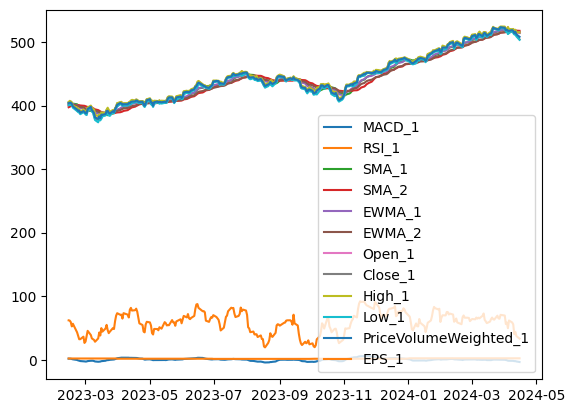

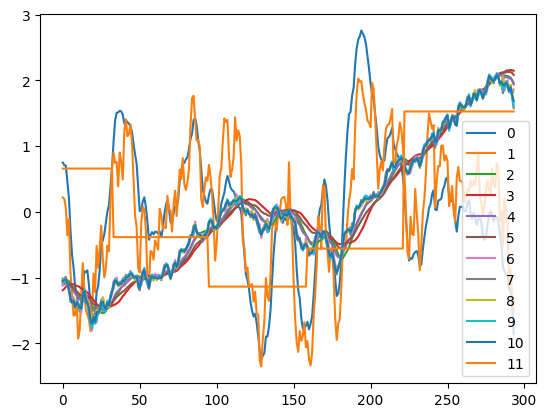

In [9]:
#Plot all features

from sklearn.preprocessing import StandardScaler

for symbol, symbol_data in data.items():
    print(symbol)
    ss = StandardScaler()
    X_ss = ss.fit_transform(symbol_data['features'])
    df_X_ss = pd.DataFrame(X_ss)
    
    
    for feature_name, feature_data in symbol_data['features'].items():
        plt.plot(feature_data, label=feature_name)
    plt.legend()
    plt.show()
    
    for feature_name, feature_data in df_X_ss.items():
        #if feature_name != 0:
        #    continue
        plt.plot(feature_data, label=feature_name)
    plt.legend()
    plt.show()


In [39]:
# Build net
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
import os

#define lstm class
class LSTMv2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMv2, self).__init__()

        #set params
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, output_size)
        
        # Activation function
        self.tanh = nn.Tanh()
        
        # Dropout layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm1(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn[-1] if self.num_layers > 1 else hn
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.tanh(self.fc1(hn))  # first Dense
        out = self.dropout(out)
        out = self.tanh(self.fc2(out)) 
        return out

        
def create_model(data, model_type, model_config):
    learning_rate = model_config['learning_rate']
    training_split = model_config['training_split']
    input_size = data['features'].shape[1]
    train_size = int(training_split * len(data['features']))
    hidden_size = model_config['hidden_size']
    num_layers = model_config['num_layers']
    training_batch_size = model_config['batch_size']
    sequence_length = model_config['sequence_length']
    patience = model_config['patience']
    weight_decay = model_config['weight_decay']


    # extract features and signals from data object. instantiate scaler objects
    X = data['features']
    y = data['signals']
    ss = StandardScaler()

    # split of x data
    X_train = X.iloc[:train_size, :]
    X_test = X.iloc[train_size:, :]

    # split up y data
    y_train = y.iloc[:train_size, :]
    y_train_index = y_train.index
    y_test = y.iloc[train_size:, :]
    y_test_index = y_test.index

    # scale training data (y does not need scaling)
    X_train_scaled = ss.fit_transform(X_train)
    y_train_scaled = y_train.values.reshape(-1, 1)
    
    # Transform testing data using the fitted scalers
    X_test_scaled = ss.transform(X_test)
    y_test_scaled = y_test.values.reshape(-1, 1)

    # Create sequences for training and testing data
    X_train_sequences = []
    y_train_sequences = []
    y_indices = []
    
    for i in range(len(X_train_scaled) - sequence_length + 1):
        X_train_sequences.append(X_train_scaled[i:i+sequence_length])
        y_train_sequences.append(y_train_scaled[i+sequence_length-1])
        y_indices.append(y_train_index[i+sequence_length-1])
    
    X_test_sequences = []
    y_test_sequences = []
    for i in range(len(X_test_scaled) - sequence_length + 1):
        X_test_sequences.append(X_test_scaled[i:i+sequence_length])
        y_test_sequences.append(y_test_scaled[i+sequence_length-1])
        y_indices.append(y_test_index[i+sequence_length-1])

    # Convert sequences to tensors
    X_train_tensors = torch.Tensor(X_train_sequences)
    y_train_tensors = torch.Tensor(y_train_sequences)
    X_test_tensors = torch.Tensor(X_test_sequences)
    y_test_tensors = torch.Tensor(y_test_sequences)

    # instatiate model
    os.environ['MASTER_ADDR'] = '10.0.0.33'
    os.environ['MASTER_PORT'] = '1234'
    os.environ['PYTHONFAULTHANDLER'] = '1'
    os.environ['GLOO_SOCKET_IFNAME'] = 'en0'
    os.environ['RANK'] = '0'
    os.environ['WORLD_SIZE'] = '2'

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train_tensors, y_train_tensors)

    

    print("process group waiting")
    dist.init_process_group(backend='gloo', rank=int(os.environ['RANK']), world_size=int(os.environ['WORLD_SIZE']))
    train_sampler = DistributedSampler(train_dataset)
    
    train_loader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle=True)
    #train_loader = DataLoader(train_dataset, batch_size=training_batch_size, sampler=train_sampler, num_workers=int(os.environ['WORLD_SIZE']), pin_memory=True)

    print("process group initialized")
    output_size = 1
    model = DDP(LSTMv2(input_size, hidden_size, num_layers, output_size))
    #model = LSTMv2(input_size, hidden_size, num_layers, output_size)
        
    # Define loss function and optimizer
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 

    # create lists and runnig vars for training
    losses = []
    best_loss = float('inf')
    epoch = 0
    counter = 0 

    # training loop
    while counter < patience:

        # set model to train
        model.train()
        batch_losses = []

        # loop through each batch in the loader
        for batch_X, batch_y in train_loader:

            # train and optimize for each batch
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        
        # Calculate average loss for the epoch
        epoch_loss = sum(batch_losses) / len(batch_losses)
        losses.append(epoch_loss)

        # eval model
        with torch.no_grad():
            model.eval()
            val_outputs = model(X_test_tensors)  # Adjust input shape for LSTM
            val_loss = criterion(val_outputs, y_test_tensors)

        # Check for improvement in validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Print progress
        curr_loss = val_loss.item()
        losses.append(curr_loss)
        print(f"Epoch: {counter}, Validation Loss: {curr_loss}")

            
    # Predict using the trained model
    with torch.no_grad():
        model.eval()
        predicted_full = model(torch.cat((X_train_tensors, X_test_tensors), dim=0)).view(-1)
        actual_full = torch.cat((y_train_tensors, y_test_tensors), dim=0).view(-1)
        predicted_series = pd.Series(predicted_full, index=y_indices)
        actual_series = pd.Series(actual_full, index=y_indices)

    # data to store for later use (making confusion graph, etc.)
    predictions = {
        'actual': actual_series,
        'predicted': predicted_series
    }
    dist.destroy_process_group();
    return model, losses, predictions

In [40]:
from sklearn.metrics import confusion_matrix

class Model:
    def __init__ (self, model, model_config, training_loss, training_data):
        self.model = model,
        self.model_config = model_config
        self.training_loss = training_loss
        self.training_data = training_data

    def graph_loss(self):
        plt.plot(self.training_loss)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def graph_confusion(self):
        y_test_np = self.training_data['actual']
        y_pred_np = self.training_data['predicted']

        threshold = 0.0
        y_pred_binary = (y_pred_np > threshold).astype(int)
        y_test_binary = (y_test_np > threshold).astype(int)
        
        # Create a confusion matrix
        conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
        
        # Display the confusion matrix using seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def graph_signals(self):
        plt.figure(figsize=(10,6)) #plotting
        #train_size = len(self.training_data['actual']) * .8
        #plt.axvline(x=train_size, c='r', linestyle='--') #size of the training set
            
        plt.plot(self.training_data['actual'], label='Actual Data') #actual plot
        plt.plot(self.training_data['predicted'], label='Predicted Data') #predicted plot
        plt.title('Time-Series Prediction')
        plt.legend()
        plt.show() 
        
    def graph_prices(self, price_data, point, zoom, mag_scale):
        start_point = int(len(price_data)*point)
        end_point = start_point+zoom
        price_data['predicted']=self.training_data['predicted']
        price_data = price_data.iloc[start_point:end_point]
        colors = ['green' if val > 0 else 'red' for val in price_data['predicted']]
        magnitudes = [abs(val) for val in price_data['predicted']]
        plt.figure(figsize=(10,6)) #plotting            
        plt.scatter(
            y=price_data['close'], 
            x=price_data.index,
            color=colors, 
            s=[mag_scale * mag for mag in magnitudes])
        plt.title('')
        plt.legend()
        plt.show()


In [ ]:
model_config = {
    #'learning_rate': .001,
    'learning_rate': .0001,
    'hidden_size': 128,
    'num_layers': 1,
    #'batch_size': 448,
    #'batch_size': 6720,
    'batch_size': 32,
    'sequence_length': 100,
    #'sequence_length': 1,
    'patience': 10,
    'training_split': .8,
    'weight_decay': 0.001
}
max_attempts = 3

models = {}

num_models = 1

for symbol, symbol_data in data.items():
    symbol_map = {}
    for attempt in range(1, max_attempts + 1):
        try:
            model, training_loss, predictions = create_model(data=symbol_data, model_type='LSTMv2', model_config=model_config)
            data[symbol]['predictions'] = predictions
            TrainedModel = Model(model, model_config, training_loss, predictions)
            models[symbol] = TrainedModel
            break
        except ValueError as e:
            print(f"Caught an error on attempt {attempt}: {e}")
    else:
        print(f"Function failed after {max_attempts} attempts.")


process group waiting
process group initialized


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([1, 32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [42]:
dist.destroy_process_group();


SPY


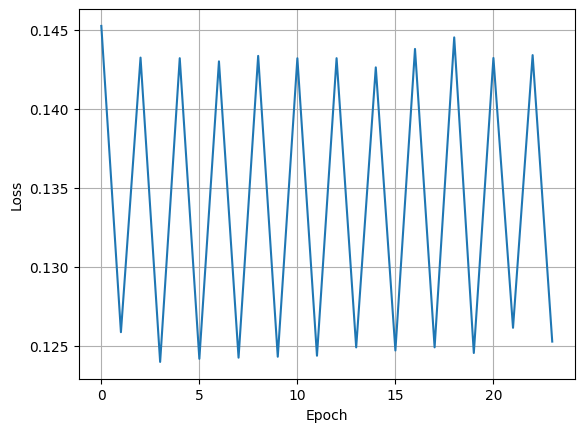

In [34]:
for symbol, model in models.items():
    print(symbol)
    model.graph_loss()

SPY


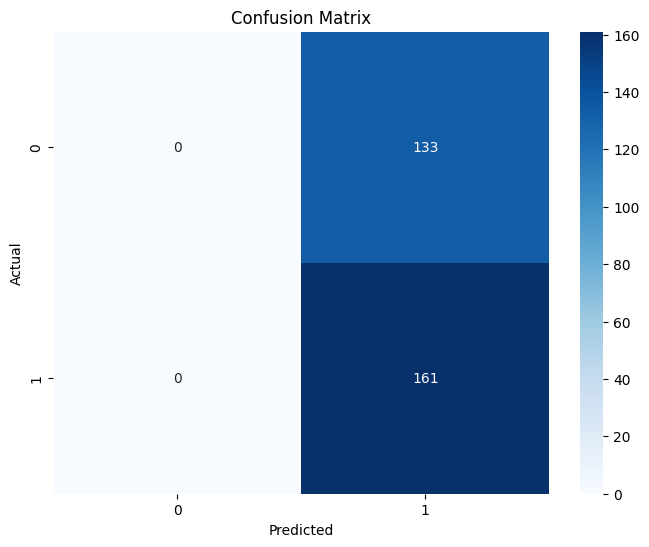

In [19]:
for symbol, model in models.items():
    print(symbol)
    model.graph_confusion()

SPY


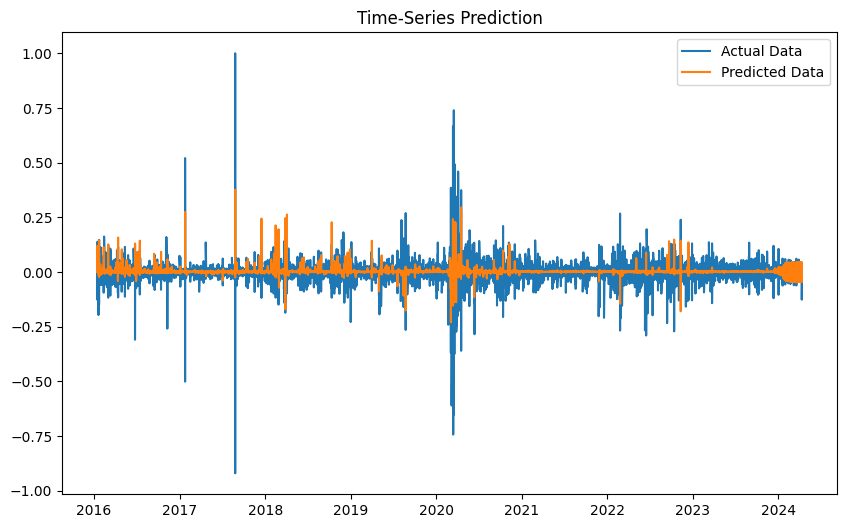

In [48]:
for symbol, model in models.items():
    print(symbol)
    model.graph_signals()

SPY


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


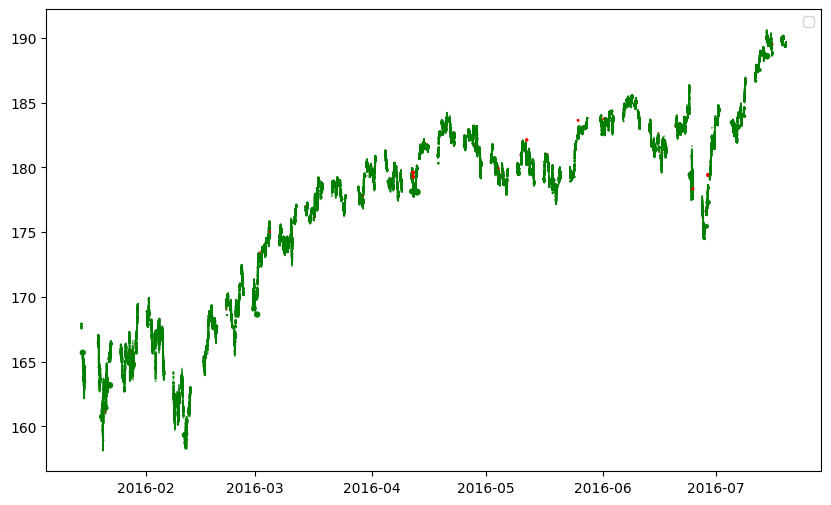

In [50]:
for symbol, model in models.items():
    print(symbol)
    model.graph_prices(data[symbol]['bars'], 0, 100000, 100)

/var/folders/cc/tg_0k3g51mxb3znqc5b2dwn80000gn/T/ipykernel_66645/3457511836.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_movement = price_data[index+1]-price_data[index]


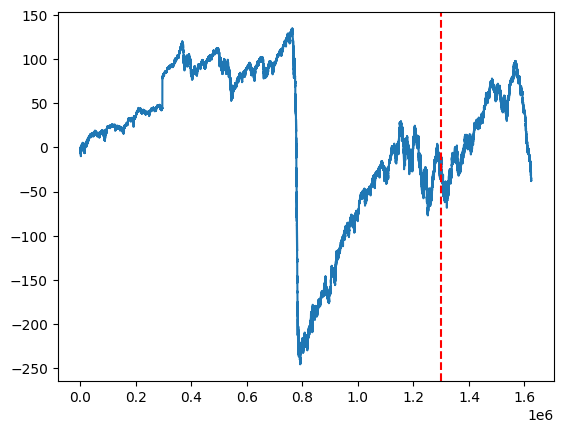

In [51]:
def simulate(symbol):
    gains = []
    running_gain = 0
    running_gain_history = []

    predictions = data[symbol]['predictions']['predicted']
    price_data = data[symbol]['bars']['close']

    for index, prediction in enumerate(predictions):
        future_movement = price_data[index+1]-price_data[index]
        gain = 0
        if (prediction*future_movement > 0):
            gain = abs(future_movement)
        else:
            # print(prediction)
            # print(f'{price_data[index]}->{price_data[index+1]}')
            # print()
            gain = -abs(future_movement)
        gains.append(gain)
        running_gain += gain
        running_gain_history.append(running_gain)
    plt.plot(running_gain_history)
    plt.axvline(x=(len(running_gain_history)*.8), color='r', linestyle='--')

simulate('SPY')


In [52]:
total_same_sign = 0
running_tally = 0
count = 0
tail = int(len(data['SPY']['predictions']['actual']) * .2)
for index in data['SPY']['predictions']['actual'].tail(tail).index:
    if data['SPY']['predictions']['actual'][index] * data['SPY']['predictions']['predicted'][index] > 0:
        total_same_sign += 1
        count += 1
        running_tally += abs(data['SPY']['predictions']['actual'][index])
print(total_same_sign/len(data['SPY']['predictions']['predicted'].tail(tail)))

0.46869410210861084


In [60]:
modelsOld = models

In [54]:
print(models['SPY'].model[0].state_dict())

OrderedDict({'lstm1.weight_ih_l0': tensor([[-8.1391e-03, -1.4076e+00,  5.0997e-01,  ...,  5.3491e-01,
          2.7746e-01, -5.7373e+00],
        [ 6.7939e+00, -4.2902e+00, -4.6679e+00,  ..., -4.7236e+00,
         -4.4432e+00, -9.7568e+00],
        [-1.7203e-01,  1.5887e+00,  2.2772e+00,  ...,  1.9508e+00,
          2.3995e+00,  2.0751e-01],
        ...,
        [-4.1745e-01,  2.2913e+00,  3.0186e-01,  ...,  3.9574e-01,
          4.1684e-01, -8.6456e+00],
        [ 4.9950e-01,  2.7022e+00,  4.3616e+00,  ...,  3.2968e+00,
          2.8457e+00, -1.0481e+01],
        [ 1.2534e+00,  7.4831e-01, -1.8872e+00,  ..., -1.5568e+00,
         -1.6236e+00, -1.2425e+00]]), 'lstm1.weight_hh_l0': tensor([[-1.0189e+01,  5.5267e-02, -9.6801e-02,  ...,  4.8922e-01,
         -6.8269e-01,  4.5942e-02],
        [ 7.4427e-02,  1.9748e+01, -3.3902e-01,  ..., -1.0930e-01,
         -2.6746e-02,  3.0167e-02],
        [ 8.6761e-02, -1.2525e-02,  7.3330e-02,  ...,  1.2598e-02,
         -9.2231e-02,  2.4398e-01],
 

##### conn = sqlite3.connect('/Users/davidmutascio/sqlite3_dbs/enigmaDev.db')
data[symbol]['bars'].to_sql("test", conn, if_exists='replace', index=False)
    
    # Save (commit) the changes
conn.commit()
conn.close()
